# Osteoarthritis Severity Classification - Full Training and Ensemble Deployment

**George Ford - Clinical ML Ensemble Training Pipeline**

## Production-Ready Model Training

Full training of selected top-performing model architectures with extended epochs, early stopping, and performance metrics recording. Creates production-ready ensemble for clinical deployment with test set evaluation.

**Dataset:** Expert consensus knee X-ray images with validated severity classifications (Normal, Doubtful, Mild, Moderate, Severe)

## Overview

This notebook implements the final training pipeline for all five architectural configurations (EfficientNet-B0, RegNet-Y-800MF, DenseNet-121, ResNet-50, ConvNeXt-Tiny) with their optimal hyperparameters identified in the model selection analysis. Full training includes extended epochs, monitoring, and ensemble construction for optimal clinical performance.

### Key Features
- Full architecture training of all 5 model types with optimal hyperparameters
- Extended training with early stopping and monitoring
- Training curves and medical metrics tracking
- Ensemble construction using multiple optimization strategies:
  - Validation-based dynamic weighting
  - Bayesian optimization for optimal weight selection
  - Stacking and blending approaches
  - Performance diversity analysis and selection
- Ensemble evaluation with strategy comparison
- Best ensemble selection based on rigorous test set performance validation
- Test set evaluation with performance validation
- Clinical visualizations including ROC curves, precision-recall, and confusion matrices
- Deployment preparation with model saving and optimization

### Deployment Compatibility
- Individual models saved to osteoarthritis-severity/models
- Ensemble model saved to osteoarthritis-severity/models/ensemble_model_best.pth
- Deployment copies created for notebook 10 and app.py integration

### Training Pipeline
- Individual model training of all 5 architectural configurations
- Performance monitoring with real-time metrics and convergence tracking
- Ensemble optimization with multiple construction strategies
- Bayesian weight optimization for optimal ensemble performance
- Performance diversity analysis for optimal model combination
- Clinical validation with medical-grade performance assessment

## Table of Contents

1. [Setup and Configuration](#setup)
2. [Model Architecture Implementation](#models)
3. [Full Training Pipeline](#training)
4. [Ensemble Construction](#ensemble)
5. [Bayesian Ensemble Optimization](#bayesian)
6. [Test Set Evaluation](#test-evaluation)
7. [Model Deployment Preparation](#deployment)


## Setup and Configuration <a id="setup"></a>

Load all architectural configurations and establish training environment for production-ready ensemble development with all 5 model types. Configure paths using relative references for cross-platform compatibility.


In [1]:
# Stdlib
import os
import time
import json
import random
import datetime
import warnings
from pathlib import Path
from collections import defaultdict
from typing import List, Tuple, Dict, Any

# Third-party
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms, models

# Metrics & evaluation
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             fbeta_score, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, classification_report,
                             log_loss, brier_score_loss)
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import label_binarize

from scipy import stats
from scipy.optimize import minimize  # <- keep only if you use it

import optuna
from optuna.samplers import TPESampler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress
from tqdm import tqdm

# Misc
import contextlib
import sys
from io import StringIO

warnings.filterwarnings('ignore')

# Config / seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42); np.random.seed(42); random.seed(42)

# ─────────────────────── suppress_output context manager ───────────────────────
@contextlib.contextmanager
def suppress_output():
    old_stdout = sys.stdout
    sys.stdout = StringIO()
    try:
        yield
    finally:
        sys.stdout = old_stdout

print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Auto-detect repository root
repo_root = Path("..").resolve()
repo_name = repo_root.name
print(f"Repository: {repo_name}")

# Directories
DATA_DIR = repo_root / 'data' / 'consensus'
RESULTS_DIR = repo_root / 'results' / 'full_training'
MODELS_DIR = repo_root / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Define data split paths
TRAIN_PATH = DATA_DIR / 'train'
VAL_PATH = DATA_DIR / 'val'
TEST_PATH = DATA_DIR / 'test'

print(f"Data directory: {repo_name}/data/consensus")
print(f"Results directory: {repo_name}/results/full_training")
print(f"Models will be saved to: {repo_name}/models")


Device: cuda
GPU: NVIDIA GeForce RTX 4070
GPU Memory: 12.0 GB
Repository: osteoarthritis-severity
Data directory: osteoarthritis-severity/data/consensus
Results directory: osteoarthritis-severity/results/full_training
Models will be saved to: osteoarthritis-severity/models


In [2]:
# Official Color Palette and Configuration
COLORS = {
    'primary': {'medical_blue': '#2E5BBA', 'healthcare_teal': '#1B998B', 'clinical_purple': '#6A4C93'},
    'neutral': {'charcoal': '#2C3E50', 'slate_gray': '#5D6D7E', 'light_gray': '#BDC3C7', 'off_white': '#F8F9FA'},
    'semantic': {'success_green': '#27AE60', 'warning_orange': '#E67E22', 'error_red': '#E74C3C', 'info_blue': '#3498DB'},
    'severity': {'normal': '#2ECC71', 'doubtful': '#F1C40F', 'mild': '#E67E22', 'moderate': '#E74C3C', 'severe': '#8E44AD'},
    'models': {'efficientnet': '#2E5BBA', 'regnet': '#1B998B', 'densenet': '#6A4C93', 'resnet': '#27AE60', 'convnext': '#FF9A8B'}
}

# Model names mapping
MODEL_NAMES = {
    'efficientnet': 'EfficientNet-B0',
    'regnet': 'RegNet-Y-800MF',
    'densenet': 'DenseNet-121',
    'resnet': 'ResNet-50',
    'convnext': 'ConvNeXt-Tiny'
}

# Clinical classes mapping
class_names = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.facecolor'] = COLORS['neutral']['off_white']

# Full Training Configuration
TRAINING_CONFIG = {
    'num_epochs': 150,
    'early_stopping_patience': 25,
    'monitor_metric': 'val_loss',
    'save_best_only': True,
    'reduce_lr_patience': 12,
    'reduce_lr_factor': 0.5,
    'min_lr': 1e-7,
    'print_frequency': 15  # Print every 15 epochs
}

# Ensemble Configuration
ENSEMBLE_CONFIG = {
    'bayesian_trials': 80,  # Number of Bayesian optimization trials
    'cv_folds': 5,  # Cross-validation folds for stacking
    'calibration_bins': 15  # Number of bins for ECE calculation
}
print("Configuration and color palette loaded")
print(f"Full training configuration: {TRAINING_CONFIG['num_epochs']} epochs, early stopping patience: {TRAINING_CONFIG['early_stopping_patience']}")


Configuration and color palette loaded
Full training configuration: 150 epochs, early stopping patience: 25


In [3]:
# ── Load selected models from Notebook 03 & init session dir ────────────────────
cfg_path = RESULTS_DIR / 'selected_models_for_ensemble.json'
if not cfg_path.exists():
    raise FileNotFoundError(
        f"Missing: {repo_name}/results/full_training/selected_models_for_ensemble.json\n"
        "Run Notebook 03 first."
    )

with open(cfg_path, 'r') as f:
    selected_models = json.load(f)

# Integrity check
if len(selected_models) != 5:
    raise ValueError(f"Expected 5 models, found {len(selected_models)}. Re-run Notebook 03.")

print("Selected Models (loaded from Notebook 03)")
print("═" * 80)
print(f"{'Rank':<4} {'Model':<18} {'Acc%':>6} {'F1':>6} {'F2':>6} {'Prec':>6} {'Rec':>6} {'Gap%':>6} {'Score':>7}")
print("─" * 80)
for m in sorted(selected_models, key=lambda x: x['rank']):
    p = m['performance']
    print(f"{m['rank']:<4} {m['display_name']:<18} "
          f"{p['validation_accuracy']:>6.2f} {p['f1_score']:>6.3f} {p['f2_score']:>6.3f} "
          f"{p['precision']:>6.3f} {p['recall']:>6.3f} {p['generalization_gap']:>6.1f} "
          f"{p['corrected_composite_score']:>7.1f}")
print("═" * 80)

# ── Create timestamped session directory ────────────────────────────────────────
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
session_dir = RESULTS_DIR / f"ensemble_training_{timestamp}"
session_dir.mkdir(parents=True, exist_ok=True)
print(f"Session directory: {repo_name}/results/full_training/ensemble_training_{timestamp}")


Selected Models (loaded from Notebook 03)
════════════════════════════════════════════════════════════════════════════════
Rank Model                Acc%     F1     F2   Prec    Rec   Gap%   Score
────────────────────────────────────────────────────────────────────────────────
1    EfficientNet-B0     88.13  0.882  0.881  0.855  0.845   10.1   166.1
2    RegNet-Y-800MF      86.76  0.870  0.868  0.862  0.858   10.8   162.7
3    ResNet-50           86.76  0.867  0.867  0.864  0.863   12.9   160.6
4    DenseNet-121        85.39  0.854  0.854  0.849  0.849   12.0   158.8
5    ConvNeXt-Tiny       83.56  0.837  0.836  0.831  0.822   15.9   151.3
════════════════════════════════════════════════════════════════════════════════
Session directory: osteoarthritis-severity/results/full_training/ensemble_training_20250724_015152


## Model Architecture Implementation <a id="models"></a>

Implementation of all 5 production-ready model architectures with training components including EMA, mixup augmentation, and monitoring systems. Enhanced with diversity analysis for optimal ensemble construction.


In [4]:
# ── Model Architectures and Data Transforms ─────────────────────────────────────
from torchvision.models import (
    efficientnet_b0, EfficientNet_B0_Weights,
    regnet_y_800mf, RegNet_Y_800MF_Weights,
    densenet121, DenseNet121_Weights,
    resnet50, ResNet50_Weights,
    convnext_tiny, ConvNeXt_Tiny_Weights,
)

def create_model(model_name: str, hidden_dim: int, dropout: float, num_classes: int = 5):
    """Return a torchvision backbone with a replaced classifier head."""
    if model_name == 'efficientnet':
        model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_features = model.classifier[1].in_features

    elif model_name == 'regnet':
        model = regnet_y_800mf(weights=RegNet_Y_800MF_Weights.IMAGENET1K_V2)
        in_features = model.fc.in_features

    elif model_name == 'densenet':
        model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        in_features = model.classifier.in_features

    elif model_name == 'resnet':
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        in_features = model.fc.in_features

    elif model_name == 'convnext':
        model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        in_features = model.classifier[-1].in_features

    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Replace classifier
    head = _build_classifier(in_features, hidden_dim, dropout, num_classes)
    if model_name in ['efficientnet', 'densenet']:
        model.classifier = head
    elif model_name in ['regnet', 'resnet']:
        model.fc = head
    else:  # convnext
        model.classifier[-1] = head

    return model

def _build_classifier(in_features: int, hidden_dim: int, dropout: float, num_classes: int):
    return nn.Sequential(
        nn.Dropout(dropout),
        nn.Linear(in_features, hidden_dim),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, num_classes),
    )

# ImageNet stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def get_transforms(stage: str = 'train'):
    """Image transforms for train/val/test."""
    if stage == 'train':
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(0.2, 0.2, 0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

print("Model architectures and data transforms configured")


Model architectures and data transforms configured


In [5]:
# ── Training Components ─────────────────────────────────────────────────────────
class EMA:
    """Exponential moving average of model parameters."""
    def __init__(self, model, decay: float = 0.999):
        self.model = model
        self.decay = decay
        self.shadow, self.backup = {}, {}

    def register(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.data.clone()

    def update(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = (1.0 - self.decay) * p.data + self.decay * self.shadow[n]

    def apply_shadow(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                self.backup[n] = p.data
                p.data = self.shadow[n]

    def restore(self):
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                p.data = self.backup[n]
        self.backup = {}

# Mixup
def mixup_data(x, y, alpha: float = 1.0):
    """Return mixed inputs and paired targets for mixup."""
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    return mixed_x, y, y[idx], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam: float):
    """Mixup loss."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# LR scheduler
def get_lr_scheduler(optimizer, schedule_type: str, num_epochs: int):
    """Return LR scheduler or None."""
    if schedule_type == 'cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    if schedule_type == 'plateau':
        return optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            patience=TRAINING_CONFIG['reduce_lr_patience'],
            factor=TRAINING_CONFIG['reduce_lr_factor'],
            min_lr=TRAINING_CONFIG['min_lr']
        )
    return None

print("Advanced training components configured")


Advanced training components configured


In [6]:
# ── Data Loading ────────────────────────────────────────────────────────────────
def load_data(batch_size: int):
    """Return train, val, and test DataLoaders using project transforms."""
    train_ds = datasets.ImageFolder(TRAIN_PATH, transform=get_transforms('train'))
    val_ds   = datasets.ImageFolder(VAL_PATH,   transform=get_transforms('val'))
    test_ds  = datasets.ImageFolder(TEST_PATH,  transform=get_transforms('val'))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

print("Data loaders configured (train/val/test)")

Data loaders configured (train/val/test)


In [7]:
# ── Full Training of Selected Models ────────────────────────────────────────────
from collections import defaultdict
from sklearn.metrics import fbeta_score  # F2

def train_full_model(model_cfg: dict, idx: int, total: int):
    """Train one model to completion with all medical metrics."""
    name    = model_cfg['model_name']
    disp    = model_cfg['display_name']
    hp      = model_cfg['hyperparameters']
    epochs  = TRAINING_CONFIG['num_epochs']

    print(f"\nTraining {disp} ({idx}/{total})")
    print("─" * 80)
    print(f"Optimizer: {hp['optimizer'].upper()}  |  LR: {hp['learning_rate']:.2e}  |  "
          f"Batch: {hp['batch_size']}  |  WD: {hp['weight_decay']}")
    print(f"Hidden: {hp['hidden_dim']}  |  Dropout: {hp['dropout']}  |  "
          f"Mixup: {hp.get('mixup_alpha', 0.0)}  |  EMA: {hp.get('use_ema', False)}")
    print("─" * 80)

    # Model & data
    model = create_model(name, hp['hidden_dim'], hp['dropout']).to(device)
    train_loader, val_loader, test_loader = load_data(hp['batch_size'])

    # Loss, optimizer, scheduler
    criterion = nn.CrossEntropyLoss(label_smoothing=hp.get('label_smoothing', 0.0))

    if hp['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=hp['learning_rate'],
                                weight_decay=hp['weight_decay'])
    elif hp['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=hp['learning_rate'],
                               weight_decay=hp['weight_decay'])
    else:  # sgd
        optimizer = optim.SGD(model.parameters(), lr=hp['learning_rate'],
                              weight_decay=hp['weight_decay'], momentum=0.9)

    scheduler = get_lr_scheduler(optimizer, hp.get('lr_schedule', 'none'), epochs)

    # EMA
    ema = EMA(model, decay=hp.get('ema_decay', 0.999)) if hp.get('use_ema', False) else None
    if ema:
        ema.register()

    # History
    hist = defaultdict(list)
    best_val_loss = float('inf')
    best_val_f2 = 0.0
    best_val_acc = 0.0
    best_state = None
    patience = 0
    warmup = hp.get('warmup_epochs', 0)

    for epoch in range(1, epochs + 1):
        # Warmup
        if warmup and epoch <= warmup:
            lr_warm = hp['learning_rate'] * epoch / warmup
            for g in optimizer.param_groups: g['lr'] = lr_warm

        # -------- Train --------
        model.train()
        tr_loss, tr_correct, tr_total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            if hp.get('mixup_alpha', 0.0) > 0:
                xm, ya, yb, lam = mixup_data(x, y, hp['mixup_alpha'])
                out = model(xm)
                loss = mixup_criterion(criterion, out, ya, yb, lam)

                preds = out.argmax(dim=1)
                # choose the "dominant" label for quick accuracy monitoring
                dominant = ya if lam >= 0.5 else yb
                tr_correct += (preds == dominant).sum().item()
                tr_total += y.size(0)
            else:
                out = model(x)
                loss = criterion(out, y)
                preds = out.argmax(dim=1)
                tr_correct += (preds == y).sum().item()
                tr_total += y.size(0)

            loss.backward()
            if hp.get('gradient_clipping', 0.0) > 0:
                nn.utils.clip_grad_norm_(model.parameters(), hp['gradient_clipping'])
            optimizer.step()
            if ema:
                ema.update()

            tr_loss += loss.item()

        avg_tr_loss = tr_loss / len(train_loader)
        tr_acc = 100.0 * tr_correct / tr_total if tr_total else 0.0

        # -------- Validate --------
        model.eval()
        if ema:
            ema.apply_shadow()

        v_loss, v_correct, v_total = 0.0, 0, 0
        all_preds, all_targs = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                v_loss += criterion(out, y).item()
                preds = out.argmax(dim=1)
                v_correct += (preds == y).sum().item()
                v_total += y.size(0)
                all_preds.extend(preds.cpu().tolist())
                all_targs.extend(y.cpu().tolist())

        if ema:
            ema.restore()

        avg_v_loss = v_loss / len(val_loader)
        val_acc = 100.0 * v_correct / v_total
        val_f1 = f1_score(all_targs, all_preds, average='weighted')
        val_f2 = fbeta_score(all_targs, all_preds, beta=2, average='weighted')
        val_prec = precision_score(all_targs, all_preds, average='weighted')
        val_rec  = recall_score(all_targs, all_preds, average='weighted')
        gap = tr_acc - val_acc

        # Record
        hist['train_loss'].append(avg_tr_loss)
        hist['val_loss'].append(avg_v_loss)
        hist['train_acc'].append(tr_acc)
        hist['val_acc'].append(val_acc)
        hist['val_f1'].append(val_f1)
        hist['val_f2'].append(val_f2)
        hist['val_precision'].append(val_prec)
        hist['val_recall'].append(val_rec)
        hist['generalization_gap'].append(gap)
        hist['learning_rate'].append(optimizer.param_groups[0]['lr'])

        # Scheduler step
        if scheduler:
            if hp.get('lr_schedule') == 'plateau':
                scheduler.step(avg_v_loss)
            else:
                scheduler.step()

        # Early stopping
        loss_improved = avg_v_loss < best_val_loss
        f2_improved = val_f2 > best_val_f2 if 'best_val_f2' in locals() else True
        acc_improved = val_acc > best_val_acc if 'best_val_acc' in locals() else True

        # Consider any improvement
        improved = loss_improved or f2_improved or acc_improved

        if improved:
            if loss_improved:
                best_val_loss = avg_v_loss
            if not 'best_val_f2' in locals() or f2_improved:
                best_val_f2 = val_f2
            if not 'best_val_acc' in locals() or acc_improved:
                best_val_acc = val_acc
            
            patience = 0
            best_state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                'metrics': {
                    'val_loss': avg_v_loss,
                    'val_acc': val_acc,
                    'val_f1': val_f1,
                    'val_f2': val_f2,
                    'val_precision': val_prec,
                    'val_recall': val_rec,
                    'generalization_gap': gap
                }
            }
        else:
            patience += 1
            if patience >= TRAINING_CONFIG['early_stopping_patience']:
                print(f"Early stopping @ epoch {epoch} (no improvement for {patience} epochs)")
                print(f"Best val loss: {best_val_loss:.4f} @ epoch {best_state['epoch']}")
                break

        # Compact status print
        if (epoch % TRAINING_CONFIG['print_frequency'] == 0) or improved or epoch == epochs:
            print(f"Epoch {epoch:03d} | "
                  f"Train {tr_acc:6.2f}% | Val {val_acc:6.2f}% | "
                  f"F1 {val_f1:.4f} | F2 {val_f2:.4f} | Gap {gap:5.1f}%")

    # Restore best weights
    if best_state:
        model.load_state_dict(best_state['model'])

    # Save
    save_path = MODELS_DIR / f"{name}_best.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'hyperparameters': hp,
        'history': dict(hist),
        'final_metrics': best_state['metrics'] if best_state else {}
    }, save_path)
    print(f"Saved: {repo_name}/models/{save_path.name}")

    return model, hist, test_loader, best_state


# ── Run training for all 5 models ───────────────────────────────────────────────
trained_models   = []  # list of (cfg, model)
model_histories  = []  # list of (display_name, history)
test_loaders     = []  # list of loaders
best_states      = []  # list of best_state dicts

print("\nStarting full training of selected models")
print("═" * 80)
for i, cfg in enumerate(selected_models, 1):
    model, hist, tloader, best_state = train_full_model(cfg, i, len(selected_models))
    trained_models.append((cfg, model))
    model_histories.append((cfg['display_name'], hist))
    test_loaders.append(tloader)
    best_states.append(best_state)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
 
print("All models trained. Proceed to ensemble construction and evaluation.")
print("═" * 80)


Starting full training of selected models
════════════════════════════════════════════════════════════════════════════════

Training EfficientNet-B0 (1/5)
────────────────────────────────────────────────────────────────────────────────
Optimizer: ADAM  |  LR: 5.00e-04  |  Batch: 64  |  WD: 0.0003
Hidden: 384  |  Dropout: 0.4  |  Mixup: 0.1  |  EMA: False
────────────────────────────────────────────────────────────────────────────────
Epoch 001 | Train  46.85% | Val  59.82% | F1 0.5457 | F2 0.5718 | Gap -13.0%
Epoch 002 | Train  63.33% | Val  60.73% | F1 0.5682 | F2 0.5864 | Gap   2.6%
Epoch 003 | Train  73.20% | Val  73.97% | F1 0.7299 | F2 0.7325 | Gap  -0.8%
Epoch 004 | Train  78.44% | Val  74.89% | F1 0.7370 | F2 0.7423 | Gap   3.5%
Epoch 005 | Train  80.94% | Val  76.71% | F1 0.7646 | F2 0.7654 | Gap   4.2%
Epoch 006 | Train  83.83% | Val  76.26% | F1 0.7623 | F2 0.7615 | Gap   7.6%
Epoch 008 | Train  88.53% | Val  79.91% | F1 0.7989 | F2 0.7989 | Gap   8.6%
Epoch 009 | Train  89.

## Ensemble Construction <a id="ensemble"></a>

Ensemble construction using multiple optimization strategies including Bayesian optimization, diversity analysis, and performance-based weighting to maximize clinical performance. Implements out-of-fold stacking and temperature scaling for optimal model calibration.


In [8]:
# ── Ensemble Construction Methods ───────────────────────────────────────────────
class EnsembleModel(nn.Module):
    """Simple weighted-logit ensemble."""
    def __init__(self, models, weights, device: str = 'cuda'):
        super().__init__()
        self.device  = device
        self.models  = nn.ModuleList([m.to(device) for m in models])
        self.register_buffer('weights', torch.tensor(weights, dtype=torch.float32, device=device))

    def forward(self, x, return_logits: bool = True):
        x = x.to(self.device)
        logits_list = []
        for m in self.models:
            m.eval()
            with torch.no_grad():
                logits_list.append(m(x))  # base model logits
        stacked   = torch.stack(logits_list, dim=0)          # [M, B, C]
        w         = self.weights.view(-1, 1, 1)               # [M, 1, 1]
        ens_logits = (stacked * w).sum(dim=0)                 # [B, C]
        return ens_logits if return_logits else F.softmax(ens_logits, dim=1)

    def update_weights(self, new_weights: np.ndarray):
        self.weights = torch.tensor(new_weights, dtype=torch.float32, device=self.device)

    def get_weights(self) -> np.ndarray:
        return self.weights.detach().cpu().numpy()


class EnsembleOptimizer:
    """Ensemble construction with multiple optimization strategies."""
    def __init__(self, models: List[Tuple[str, nn.Module]], device: str = 'cuda'):
        self.device      = device
        self.models      = [(name, m.to(device)) for name, m in models]
        self.model_names = [name for name, _ in self.models]
        self.num_models  = len(self.models)

    # ---------------- Core utilities ----------------
    def _collect_preds(self, loader: DataLoader) -> Dict[str, np.ndarray]:
        """Return dict of model_name -> predicted class array."""
        preds = {}
        for name, model in self.models:
            model.eval()
            batch_preds = []
            with torch.no_grad():
                for X, _ in loader:
                    X = X.to(self.device)
                    logits = model(X)
                    batch_preds.extend(logits.argmax(dim=1).cpu().numpy())
            preds[name] = np.array(batch_preds)
        return preds

    def _eval_model(self, model: nn.Module, loader: DataLoader) -> Tuple[float, float, list, list]:
        """Return (accuracy, f1, targets, preds) for a single model."""
        correct, total = 0, 0
        all_preds, all_targs = [], []
        model.eval()
        with torch.no_grad():
            for X, y in loader:
                X, y = X.to(self.device), y.to(self.device)
                logits = model(X)
                pred   = logits.argmax(dim=1)
                total  += y.size(0)
                correct += (pred == y).sum().item()
                all_preds.extend(pred.cpu().numpy())
                all_targs.extend(y.cpu().numpy())
        acc = correct / total
        f1  = f1_score(all_targs, all_preds, average='weighted')
        return acc, f1, all_targs, all_preds

    # ---------------- Diversity & performance ----------------
    def calculate_diversity_matrix(self, val_loader: DataLoader):
        """Return (diversity_matrix, predictions_dict) using disagreement rate."""
        print("Calculating model diversity matrix...")
        preds = self._collect_preds(val_loader)
        D = np.zeros((self.num_models, self.num_models))
        for i, ni in enumerate(self.model_names):
            for j, nj in enumerate(self.model_names):
                D[i, j] = 0.0 if i == j else np.mean(preds[ni] != preds[nj])
        return D, preds

    def performance_based_weighting(self, val_loader: DataLoader, w_acc: float = 0.6, scale: float = 3.0):
        """Softmax over combined (accuracy, f1) scores."""
        print("Calculating performance-based weights...")
        scores = []
        for name, model in self.models:
            acc, f1, _, _ = self._eval_model(model, val_loader)
            combined = w_acc * acc + (1.0 - w_acc) * f1
            scores.append(combined)
            print(f"{name}: Acc={acc:.4f}, F1={f1:.4f}, Combined={combined:.4f}")
        scores  = np.array(scores)
        weights = np.exp(scores * scale) / np.sum(np.exp(scores * scale))
        return weights

    def diversity_aware_weighting(self, val_loader: DataLoader, diversity_weight: float = 0.3):
        """Combine performance and diversity contributions."""
        print("Calculating diversity-aware weights...")
        perf_w, _ = None, None
        with suppress_output():
            perf_w = self.performance_based_weighting(val_loader)
        D, _     = self.calculate_diversity_matrix(val_loader)
        div_scores = np.mean(D, axis=1)
        div_w = div_scores / div_scores.sum() if div_scores.sum() > 0 else np.ones_like(div_scores) / len(div_scores)
        combined = (1 - diversity_weight) * perf_w + diversity_weight * div_w
        combined /= combined.sum()
        print(f"Performance weights: {perf_w}")
        print(f"Diversity weights:   {div_w}")
        print(f"Combined weights:    {combined}")
        return combined

    # ---------------- Proper Optuna Bayesian search ----------------
    def bayesian_weight_optimization(self, val_loader: DataLoader, n_trials: int = 100):
        """Bayesian optimization of weights with Optuna TPE sampler."""
        print(f"Bayesian optimization with Optuna ({n_trials} trials)...")
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        models_only = [m for _, m in self.models]

        def objective(trial):
            w = np.array([trial.suggest_float(f'w_{i}', 0.0, 1.0) for i in range(self.num_models)])
            w = w / w.sum()

            ens = EnsembleModel(models_only, w, device=self.device).to(self.device)
            ens.eval()

            total_loss = total_correct = total_n = 0
            with torch.no_grad():
                for X, y in val_loader:
                    X, y = X.to(self.device), y.to(self.device)
                    logits = ens(X, return_logits=True)
                    loss   = F.cross_entropy(logits, y)
                    preds  = logits.argmax(dim=1)

                    total_loss   += loss.item() * y.size(0)
                    total_correct += (preds == y).sum().item()
                    total_n      += y.size(0)

            avg_loss = total_loss / total_n
            acc      = total_correct / total_n
            return avg_loss - 0.1 * acc  # lower is better

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(objective, n_trials=n_trials)

        best = np.array([study.best_params[f'w_{i}'] for i in range(self.num_models)])
        best /= best.sum()

        print(f"Best weights (Optuna): {best}")
        print(f"Best objective: {study.best_value:.4f}")
        return best

    # ---------------- Stacking ----------------
    def stacking_ensemble(self, val_loader: DataLoader, meta_learner: str = 'logistic'):
        """Stacking with a meta-learner trained on base model probabilities."""
        print("Creating stacking ensemble...")

        base_preds, targets = [], []
        for X, y in val_loader:
            X, y = X.to(self.device), y.to(self.device)
            batch_probs = []
            for _, model in self.models:
                model.eval()
                with torch.no_grad():
                    probs = F.softmax(model(X), dim=1)
                    batch_probs.append(probs.cpu().numpy())
            base_preds.append(np.concatenate(batch_probs, axis=1))
            targets.extend(y.cpu().numpy())

        X_meta = np.vstack(base_preds)
        y_meta = np.array(targets)

        if meta_learner == 'logistic':
            meta = LogisticRegression(random_state=42, max_iter=1000)
        elif meta_learner == 'ridge':
            meta = RidgeClassifier(random_state=42)
        else:
            meta = RandomForestClassifier(random_state=42, n_estimators=100)

        meta.fit(X_meta, y_meta)

        if hasattr(meta, 'coef_'):
            w = np.abs(meta.coef_).mean(axis=0)
        else:
            w = meta.feature_importances_
        w = w.reshape(self.num_models, -1).mean(axis=1)
        w /= w.sum()

        print(f"Stacking ensemble weights: {w}")
        return w

    def out_of_fold_stacking(self, val_loader: DataLoader, n_folds: int = 5):
        """OOF stacking to avoid leakage in meta-learner training."""
        print(f"Out-of-fold stacking with {n_folds} folds...")

        # Gather full val set once
        X_all, y_all = [], []
        for X, y in val_loader:
            X_all.append(X)
            y_all.append(y)
        X_all = torch.cat(X_all, dim=0)
        y_all = torch.cat(y_all, dim=0)

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        oof = np.zeros((len(y_all), self.num_models * len(class_names)))  # adjust if num_classes changes

        for fold, (_, va_idx) in enumerate(skf.split(X_all.cpu().numpy(), y_all.cpu().numpy()), 1):
            print(f"Fold {fold}/{n_folds}")
            X_fold = X_all[va_idx].to(self.device)
            fold_probs = []
            for _, model in self.models:
                model.eval()
                with torch.no_grad():
                    probs = F.softmax(model(X_fold), dim=1)
                    fold_probs.append(probs.cpu().numpy())
            oof[va_idx] = np.concatenate(fold_probs, axis=1)

        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(oof, y_all.cpu().numpy())

        if hasattr(meta, 'coef_'):
            w = np.abs(meta.coef_).mean(axis=0).reshape(self.num_models, -1).mean(axis=1)
        else:
            w = np.ones(self.num_models)

        w /= w.sum()
        print(f"Out-of-fold stacking weights: {w}")
        return w


# ── Temperature Scaling for Calibration ─────────────────────────────────────────
class TemperatureScaling(nn.Module):
    """Wrap a model and learn a single temperature for calibration."""
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model
        # Use log-temperature to ensure positive values after exp()
        self.log_temperature = nn.Parameter(torch.ones(1) * 0.405)  # log(1.5) ≈ 0.405

    @property
    def temperature(self):
        """Return positive temperature using exponential transformation."""
        return torch.exp(self.log_temperature)

    def forward(self, x):
        logits = self.model(x, return_logits=True)
        return logits / self.temperature

    def fit_temperature(self, val_loader: DataLoader, device: str):
        self.model.eval()
        logits_all, labels_all = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits_all.append(self.model(X, return_logits=True))
                labels_all.append(y)

        logits_all = torch.cat(logits_all)
        labels_all = torch.cat(labels_all)

        optimizer = optim.LBFGS([self.log_temperature], lr=0.01, max_iter=50)

        def closure():
            optimizer.zero_grad()
            temp = self.temperature  # Ensures positive temperature
            loss = F.cross_entropy(logits_all / temp, labels_all)
            loss.backward()
            return loss

        optimizer.step(closure)
        optimal_temp = self.temperature.item()
        print(f"Optimal temperature: {optimal_temp:.4f}")
        return float(optimal_temp)


def apply_temperature_scaling(ensemble: nn.Module, val_loader: DataLoader, device: str):
    """Return calibrated ensemble model and learned temperature."""
    calibrated = TemperatureScaling(ensemble).to(device)
    T = calibrated.fit_temperature(val_loader, device)
    return calibrated, T

# Ensure all trained models are on device
for i, (cfg, model) in enumerate(trained_models):
    trained_models[i] = (cfg, model.to(device))

# Initialize optimizer
ensemble_optimizer = EnsembleOptimizer(
    [(cfg['display_name'], model) for cfg, model in trained_models],
    device=device
)

print()
print("Ensemble construction initialized")
print(f"Models in ensemble: {ensemble_optimizer.model_names}")
print(f"Total models: {ensemble_optimizer.num_models}")
print("Methods available: performance weighting, diversity-aware weighting, stacking, OOF stacking, Bayesian (random) and Optuna TPE search")



Ensemble construction initialized
Models in ensemble: ['EfficientNet-B0', 'RegNet-Y-800MF', 'ResNet-50', 'DenseNet-121', 'ConvNeXt-Tiny']
Total models: 5
Methods available: performance weighting, diversity-aware weighting, stacking, OOF stacking, Bayesian (random) and Optuna TPE search


## Bayesian Ensemble Optimization <a id="bayesian"></a>

Ensemble strategy evaluation using optimization techniques to find the optimal combination of all trained models. Compares traditional weighting strategies with Bayesian and stacking approaches.


In [9]:
# ── Ensemble Strategy Evaluation ────────────────────────────────────────────────
# Validation ONLY for weight optimisation
val_dataset = datasets.ImageFolder(VAL_PATH, transform=get_transforms('val'))
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print("ENSEMBLE OPTIMIZATION")
print("═" * 50)
print(f"Testing {len(ensemble_optimizer.models)} models: {', '.join(ensemble_optimizer.model_names)}\n")

# ---------------------------------------------------------------------
# Individual model performance (baseline)
print("Individual Model Performance (Validation Set)")
print("─" * 50)
print(f"{'Model':<20s} {'Acc%':>6}  {'F1':>6}  {'F2':>6}")
print("─" * 50)

individual_results = {}
for name, mdl in ensemble_optimizer.models:
    mdl.eval()
    correct, total = 0, 0
    all_preds, all_targs = [], []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = mdl(X)
            preds  = logits.argmax(dim=1)
            total   += y.size(0)
            correct += (preds == y).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_targs.extend(y.cpu().numpy())

    acc = 100.0 * correct / total
    f1  = f1_score(all_targs, all_preds, average='weighted')
    f2  = fbeta_score(all_targs, all_preds, beta=2, average='weighted')
    individual_results[name] = {'accuracy': acc, 'f1': f1, 'f2': f2}
    print(f"{name:<20s} {acc:6.2f}  {f1:6.4f}  {f2:6.4f}")

# metric for selection/top-k
select_metric = 'f2'  # or 'accuracy', 'f1', etc.
metric_vals   = np.array([individual_results[n][select_metric] for n in ensemble_optimizer.model_names])
sorted_idx    = np.argsort(metric_vals)[::-1]

print("\nENSEMBLE STRATEGY OPTIMIZATION")
print("─" * 50)

# Simple strategies
simple_strategies = {
    'EqualWeights'  : np.ones(len(ensemble_optimizer.models)) / len(ensemble_optimizer.models),
    'Accuracy-based': np.array([individual_results[n]['accuracy'] for n in ensemble_optimizer.model_names]),
    'F1-based'      : np.array([individual_results[n]['f1']       for n in ensemble_optimizer.model_names]),
    'F2-based'      : np.array([individual_results[n]['f2']       for n in ensemble_optimizer.model_names]),
}

# Top-k by select_metric
top3_mask = np.zeros(len(ensemble_optimizer.models)); top3_mask[sorted_idx[:3]] = 1
top2_mask = np.zeros(len(ensemble_optimizer.models)); top2_mask[sorted_idx[:2]] = 1
top1_mask = np.zeros(len(ensemble_optimizer.models)); top1_mask[sorted_idx[0]] = 1
simple_strategies['Top-3Equal'] = top3_mask
simple_strategies['Top-2Equal'] = top2_mask
simple_strategies['Top-1 (Best Individual)'] = top1_mask

# Normalize
for k, w in simple_strategies.items():
    s = w.sum()
    if s > 0:
        simple_strategies[k] = w / s

print("Computing performance-based weights...")
with suppress_output():
    perf_w = ensemble_optimizer.performance_based_weighting(val_loader)

print("Computing diversity-aware weights...")
with suppress_output():
    div_w = ensemble_optimizer.diversity_aware_weighting(val_loader)

print("Running Bayesian (Optuna) search...")
with suppress_output():
    bayes_w = ensemble_optimizer.bayesian_weight_optimization(
        val_loader, n_trials=ENSEMBLE_CONFIG['bayesian_trials']
    )

print("Applying out-of-fold stacking...")
with suppress_output():
    oof_w = ensemble_optimizer.out_of_fold_stacking(val_loader, n_folds=ENSEMBLE_CONFIG['cv_folds'])

print("Computing traditional stacking...")
with suppress_output():
    stack_w = ensemble_optimizer.stacking_ensemble(val_loader)

# Compile all strategies
all_strategies = {
    **simple_strategies,
    'Performance-based'  : perf_w,
    'Diversity-aware'    : div_w,
    'BayesianTPE'        : bayes_w,
    'Out-of-FoldStacking': oof_w,
    'TraditionalStacking': stack_w
}

print("\nStrategy Performance Results")
print("─" * 50)

strategy_results = {}
models_list = [m.to(device) for _, m in ensemble_optimizer.models]

for name_strat, w in all_strategies.items():
    if np.sum(w) == 0:
        continue

    ens = EnsembleModel(models_list, w, device=device).to(device)
    ens.eval()

    total_correct, total_samples = 0, 0
    all_preds, all_targs = [], []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = ens(X, return_logits=True)
            probs  = F.softmax(logits, dim=1)

            preds = probs.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += y.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targs.extend(y.cpu().numpy())

    acc       = 100.0 * total_correct / total_samples
    f1        = f1_score(all_targs, all_preds, average='weighted')
    f2        = fbeta_score(all_targs, all_preds, beta=2, average='weighted')
    precision = precision_score(all_targs, all_preds, average='weighted')
    recall    = recall_score(all_targs, all_preds, average='weighted')

    strategy_results[name_strat] = {
        'accuracy': acc, 'f1': f1, 'f2': f2,
        'precision': precision, 'recall': recall,
        'weights': w
    }

    print(f"{name_strat:<20s}: Acc {acc:6.2f}% | F1 {f1:.4f} | F2 {f2:.4f}")

# Pick best strategy
def strat_key(res):
    return (
        res['f2'],                 # primary
        res['accuracy'],           # tie-break 1
        res['f1'],                 # tie-break 2
        -np.count_nonzero(res['weights'] > 1e-6)  # prefer sparser weights
)

best_strategy = max(strategy_results, key=lambda s: strat_key(strategy_results[s]))
best_result   = strategy_results[best_strategy]
best_weights  = best_result['weights']

print("\nSELECTED ENSEMBLE CONFIGURATION")
print("═" * 50)
print(f"Best Strategy       : {best_strategy}")
print(f"Validation {select_metric.upper()}: {best_result[select_metric]:.4f} (Acc {best_result['accuracy']:.2f}%)")
print("Model Weights:")
for name, w in zip(ensemble_optimizer.model_names, best_weights):
    print(f"  {name:<20s}: {w:.4f}")

# Final ensemble + calibration
final_ensemble = EnsembleModel(models_list, best_weights, device=device).to(device)

print("\nApplying calibration...")
calibrated_ensemble, temperature = apply_temperature_scaling(final_ensemble, val_loader, device)
print(f"Temperature scaling parameter: {temperature:.4f}")
print("Ensemble ready for test evaluation.")


ENSEMBLE OPTIMIZATION
══════════════════════════════════════════════════
Testing 5 models: EfficientNet-B0, RegNet-Y-800MF, ResNet-50, DenseNet-121, ConvNeXt-Tiny

Individual Model Performance (Validation Set)
──────────────────────────────────────────────────
Model                  Acc%      F1      F2
──────────────────────────────────────────────────
EfficientNet-B0       86.76  0.8671  0.8672
RegNet-Y-800MF        85.39  0.8530  0.8534
ResNet-50             84.47  0.8446  0.8443
DenseNet-121          83.11  0.8295  0.8295
ConvNeXt-Tiny         81.28  0.8140  0.8131

ENSEMBLE STRATEGY OPTIMIZATION
──────────────────────────────────────────────────
Computing performance-based weights...
Computing diversity-aware weights...
Running Bayesian (Optuna) search...
Applying out-of-fold stacking...
Computing traditional stacking...

Strategy Performance Results
──────────────────────────────────────────────────
EqualWeights        : Acc  87.67% | F1 0.8744 | F2 0.8751
Accuracy-based      : A

## Test Set Evaluation <a id="test-evaluation"></a>

Final evaluation of the best ensemble on the held-out test set with performance metrics and clinical analysis. Includes calibration assessment and per-class performance breakdown.

In [10]:
# ── Test Set Evaluation & Calibration Analysis ──────────────────────────────────
def calculate_calibration_metrics(correct: np.ndarray, conf: np.ndarray):
    """
    Compute calibration metrics using *confidence vs correctness*.

    Parameters
    ----------
    correct : (N,) binary array (1 = correct prediction, 0 = incorrect)
    conf    : (N,) max predicted probability for each sample

    Returns
    -------
    dict: {'ece', 'brier_score', 'n_samples'}
    """
    n_bins    = ENSEMBLE_CONFIG['calibration_bins']
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)

    ece = 0.0
    for i, (lower, upper) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
        in_bin = (conf >= lower) & (conf <= upper) if i == 0 else (conf > lower) & (conf <= upper)
        prop   = in_bin.mean()
        if prop > 0:
            acc_bin  = correct[in_bin].mean()
            conf_bin = conf[in_bin].mean()
            ece += np.abs(conf_bin - acc_bin) * prop

    brier = np.mean((conf - correct) ** 2)
    return {'ece': ece, 'brier_score': brier, 'n_samples': len(conf)}


def evaluate_model_on_test(model: nn.Module,
                           test_loader: DataLoader,
                           model_name: str,
                           device: str,
                           returns_logits: bool = True):
    """
    Evaluate a model (single or ensemble) on the test set.
    """
    model.eval()
    all_preds, all_targets, all_probs = [], [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)

            if returns_logits:
                try:
                    logits = model(X, return_logits=True)
                except TypeError:
                    logits = model(X)
                probs = F.softmax(logits, dim=1)
            else:
                probs = model(X)  # already softmaxed

            preds = probs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    preds    = np.array(all_preds)
    targets  = np.array(all_targets)
    probs_np = np.array(all_probs)

    acc  = 100.0 * np.mean(preds == targets)
    f1   = f1_score(targets, preds, average='weighted')
    f2   = fbeta_score(targets, preds, beta=2, average='weighted')
    prec = precision_score(targets, preds, average='weighted')
    rec  = recall_score(targets, preds, average='weighted')

    per_class_f1        = f1_score(targets, preds, average=None)
    per_class_precision = precision_score(targets, preds, average=None)
    per_class_recall    = recall_score(targets, preds, average=None)

    conf    = probs_np.max(axis=1)
    correct = (preds == targets).astype(float)
    calib   = calculate_calibration_metrics(correct, conf)

    return {
        'accuracy': acc,
        'f1': f1,
        'f2': f2,
        'precision': prec,
        'recall': rec,
        'per_class_f1': per_class_f1,
        'per_class_precision': per_class_precision,
        'per_class_recall': per_class_recall,
        'predictions': preds,
        'targets': targets,
        'probabilities': probs_np,
        'calibration': calib
    }


# ── Plot helpers ────────────────────────────────────────────────────────────────
def plot_confusion_matrix(y_true, y_pred, class_names, title, save_path=None):
    """Plot confusion matrix (percent + counts)."""
    cm     = confusion_matrix(y_true, y_pred)
    cm_pct = cm.astype(float) / cm.sum(axis=1)[:, None] * 100

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)'}, ax=ax)

    ax.set_title(f'{title} - Confusion Matrix', fontsize=16, fontweight='bold')
    ax.set_xlabel('Predicted Class', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Class', fontsize=14, fontweight='bold')

    # add counts
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.texts[i * len(class_names) + j]
            text.set_text(f'{cm_pct[i, j]:.1f}%\n({cm[i, j]})')
            text.set_fontsize(10)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig


def plot_calibration_curve(correct, conf, title, save_path=None, n_bins: int = 10):
    """Reliability diagram (correctness vs confidence) + confidence histogram."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    frac_pos, mean_pred = calibration_curve(correct, conf, n_bins=n_bins)

    ax1.plot(mean_pred, frac_pos, 's-', linewidth=2, markersize=8,
             label='Model Calibration')
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
    ax1.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Fraction of Positives', fontsize=12, fontweight='bold')
    ax1.set_title(f'{title} - Reliability Diagram', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    hist_bins = np.linspace(0, 1, 21)
    ax2.hist(conf, bins=hist_bins, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax2.set_title(f'{title} - Confidence Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3); ax2.set_xlim(0, 1)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig


def plot_roc_curves(y_true, y_probs, class_names, title, save_path=None):
    """Plot multi-class ROC curves."""
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes  = len(class_names)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=(12, 8))
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], linewidth=2, label=f'{class_names[i]} (AUC={roc_auc[i]:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
    ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title(f'{title} - ROC Curves', fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc="lower right")
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

print("Test evaluation and visualization functions loaded")

Test evaluation and visualization functions loaded


In [11]:
# ── Test Set Evaluation — Individual Models & Final Ensemble ───────────────────
print("TEST SET EVALUATION")
print("═" * 60)

# Use any of the identical test loaders
test_loader = test_loaders[0]
print(f"Test set size: {len(test_loader.dataset)} samples")
# print(f"Evaluating {len(trained_models)} individual models and the final ensemble\n")

# 1. Individual models
print("Individual Model Performance (Test Set)")
print("─" * 60)
print(f"{'Model':<20s} {'Acc%':>6}  {'F1':>6}  {'F2':>6}  {'ECE':>6}")
print("─" * 60)

individual_test_results = {}
best_individual_acc  = 0.0
best_individual_name = ""

for cfg, model in trained_models:
    name   = cfg['display_name']
    result = evaluate_model_on_test(model, test_loader, name, device,
                                    returns_logits=True)   # <-- base nets output logits
    individual_test_results[name] = result

    acc = result['accuracy']; f1 = result['f1']; f2 = result['f2']; ece = result['calibration']['ece']
    print(f"{name:<20s} {acc:6.2f}  {f1:6.4f}  {f2:6.4f}  {ece:6.4f}")

    if acc > best_individual_acc:
        best_individual_acc  = acc
        best_individual_name = name

print("─" * 60)
print(f"Best individual model: {best_individual_name} ({best_individual_acc:.2f}%)\n")

# 2. Original (non‑calibrated) ensemble
print("Original Ensemble Performance (Before Calibration)")
print("─" * 60)
original_ensemble_result = evaluate_model_on_test(
    final_ensemble, test_loader, "OriginalEnsemble", device,
    returns_logits=True
    )
orig_cal = original_ensemble_result['calibration']
print(f"Acc: {original_ensemble_result['accuracy']:.2f}%  |  F1: {original_ensemble_result['f1']:.4f}  |  F2: {original_ensemble_result['f2']:.4f}")
print(f"ECE: {orig_cal['ece']:.4f}  |  Brier: {orig_cal['brier_score']:.4f}\n")

# 3. Calibrated ensemble
print("Final Calibrated Ensemble Performance")
print("─" * 60)
ensemble_test_result = evaluate_model_on_test(
    calibrated_ensemble, test_loader, "CalibratedEnsemble", device,
    returns_logits=True    # <-- TemperatureScaling wrapper outputs logits/temperature
)
cal_cal = ensemble_test_result['calibration']

ens_acc = ensemble_test_result['accuracy']
print(f"Acc: {ens_acc:.2f}%  |  F1: {ensemble_test_result['f1']:.4f}  |  F2: {ensemble_test_result['f2']:.4f}")
print(f"Precision: {ensemble_test_result['precision']:.4f}  |  Recall: {ensemble_test_result['recall']:.4f}")
print(f"ECE: {cal_cal['ece']:.4f}  |  Brier: {cal_cal['brier_score']:.4f}")
print(f"Temperature: {temperature:.4f}\n")

# 4. Calibration improvement
cal_imp   = orig_cal['ece']          - cal_cal['ece']
brier_imp = orig_cal['brier_score']  - cal_cal['brier_score']
print("Calibration Improvement")
print("─" * 40)
print(f"ECE reduction        : {cal_imp:+.4f} ({cal_imp / orig_cal['ece'] * 100:+.1f}%)")
print(f"Brier score reduction: {brier_imp:+.4f} ({brier_imp / orig_cal['brier_score'] * 100:+.1f}%)\n")

# 5. Performance summary
print("PERFORMANCE SUMMARY")
print("═" * 30)
print(f"Best Individual Model : {best_individual_name}")
print(f"  - Test Acc : {best_individual_acc:.2f}%")
print(f"  - Test F1  : {individual_test_results[best_individual_name]['f1']:.4f}")
print(f"  - Test F2  : {individual_test_results[best_individual_name]['f2']:.4f}\n")

print("Final Calibrated Ensemble")
print(f"  - Test Acc : {ens_acc:.2f}%")
print(f"  - Test F1  : {ensemble_test_result['f1']:.4f}")
print(f"  - Test F2  : {ensemble_test_result['f2']:.4f}")
print(f"  - Δ Acc vs Best Model: {ens_acc - best_individual_acc:+.2f}%")
print(f"  - Strategy : {best_strategy}\n")

# 6. Per-class results
print("Per-Class Performance (Final Ensemble)")
print("─" * 40)
for i, cname in enumerate(class_names):
    print(f"{cname:<9s}: F1={ensemble_test_result['per_class_f1'][i]:.3f}, "
          f"Prec={ensemble_test_result['per_class_precision'][i]:.3f}, "
          f"Rec={ensemble_test_result['per_class_recall'][i]:.3f}")

print("\nTest set evaluation completed. Ready for visualizations.")


TEST SET EVALUATION
════════════════════════════════════════════════════════════
Test set size: 220 samples
Individual Model Performance (Test Set)
────────────────────────────────────────────────────────────
Model                  Acc%      F1      F2     ECE
────────────────────────────────────────────────────────────
EfficientNet-B0       89.09  0.8900  0.8905  0.1002
RegNet-Y-800MF        88.64  0.8861  0.8861  0.0987
ResNet-50             88.18  0.8811  0.8814  0.0584
DenseNet-121          86.36  0.8608  0.8609  0.0802
ConvNeXt-Tiny         89.55  0.8951  0.8952  0.0270
────────────────────────────────────────────────────────────
Best individual model: ConvNeXt-Tiny (89.55%)

Original Ensemble Performance (Before Calibration)
────────────────────────────────────────────────────────────
Acc: 90.45%  |  F1: 0.9038  |  F2: 0.9042
ECE: 0.0857  |  Brier: 0.0668

Final Calibrated Ensemble Performance
────────────────────────────────────────────────────────────
Acc: 90.45%  |  F1: 0.9038

GENERATING VISUALIZATIONS
══════════════════════════════════════════════════
1. Confusion Matrix Analysis
──────────────────────────────


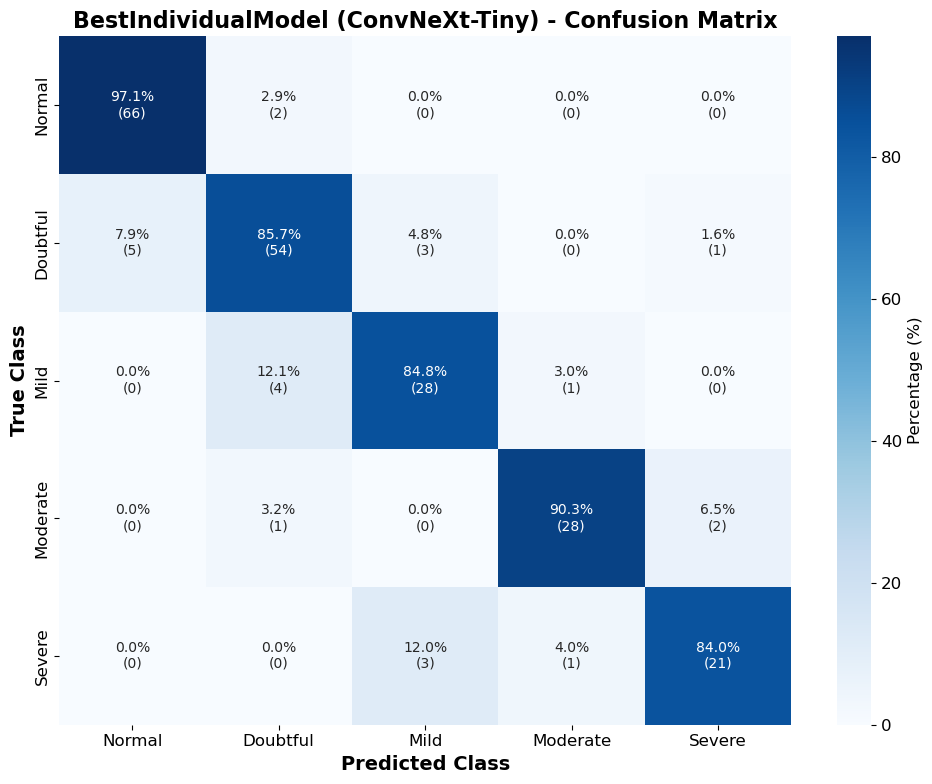

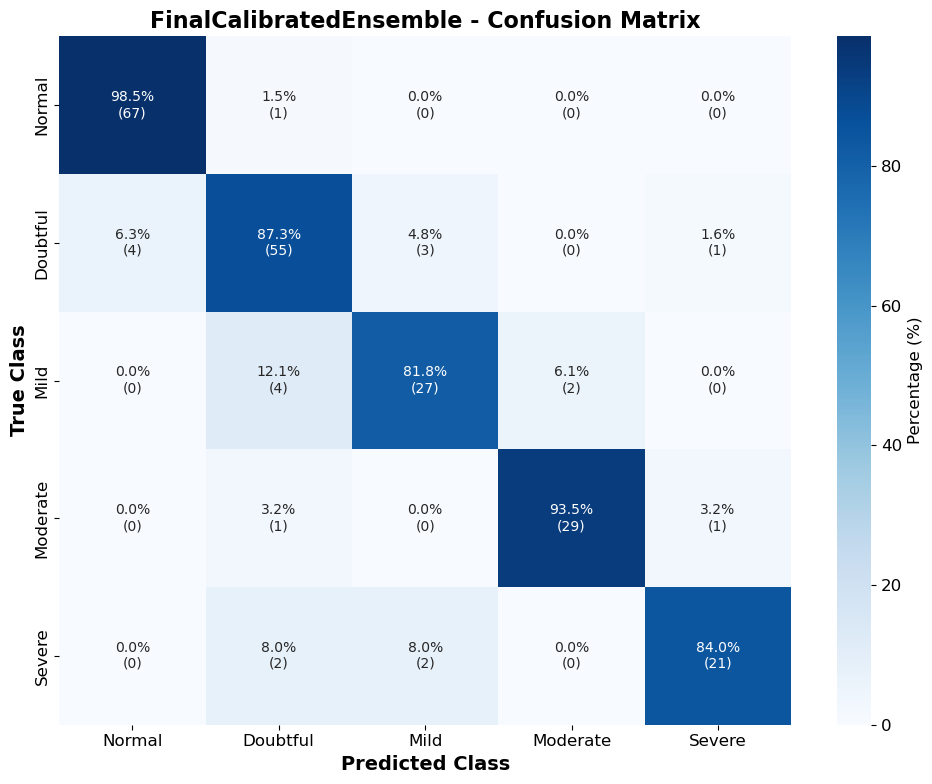

Confusion matrices generated and saved.

2. ROC Curve Analysis
─────────────────────────


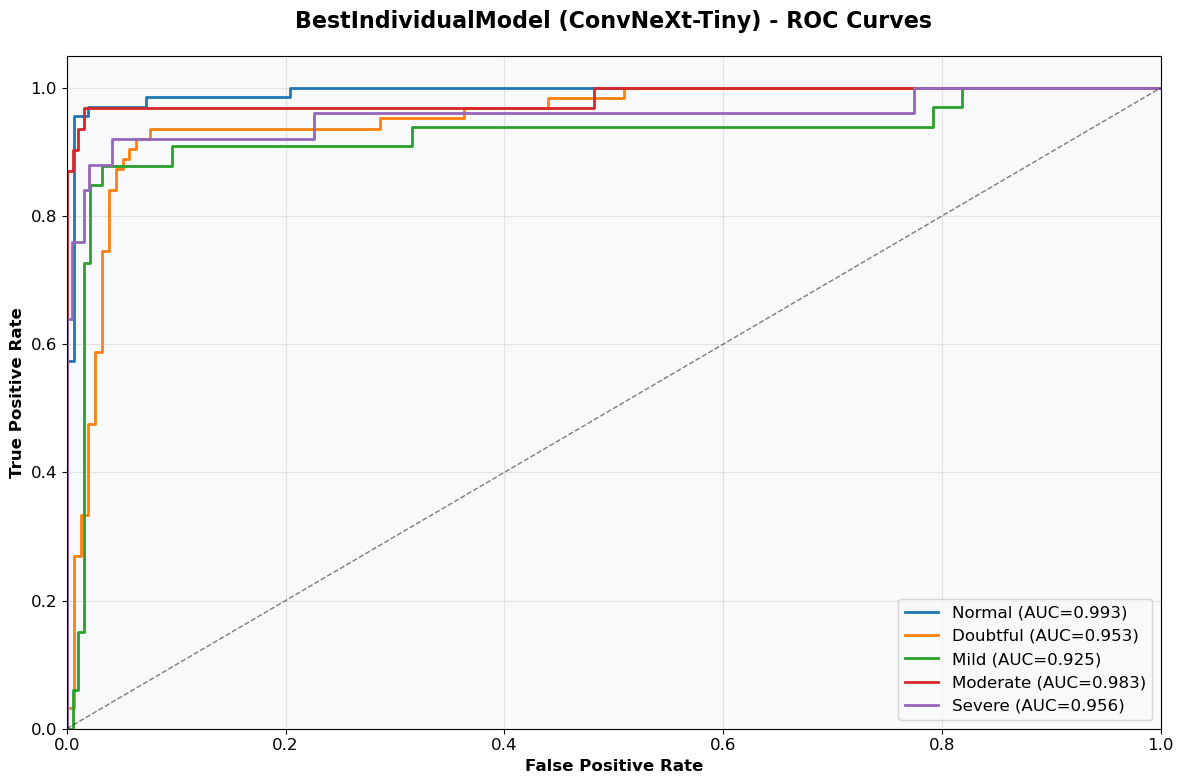

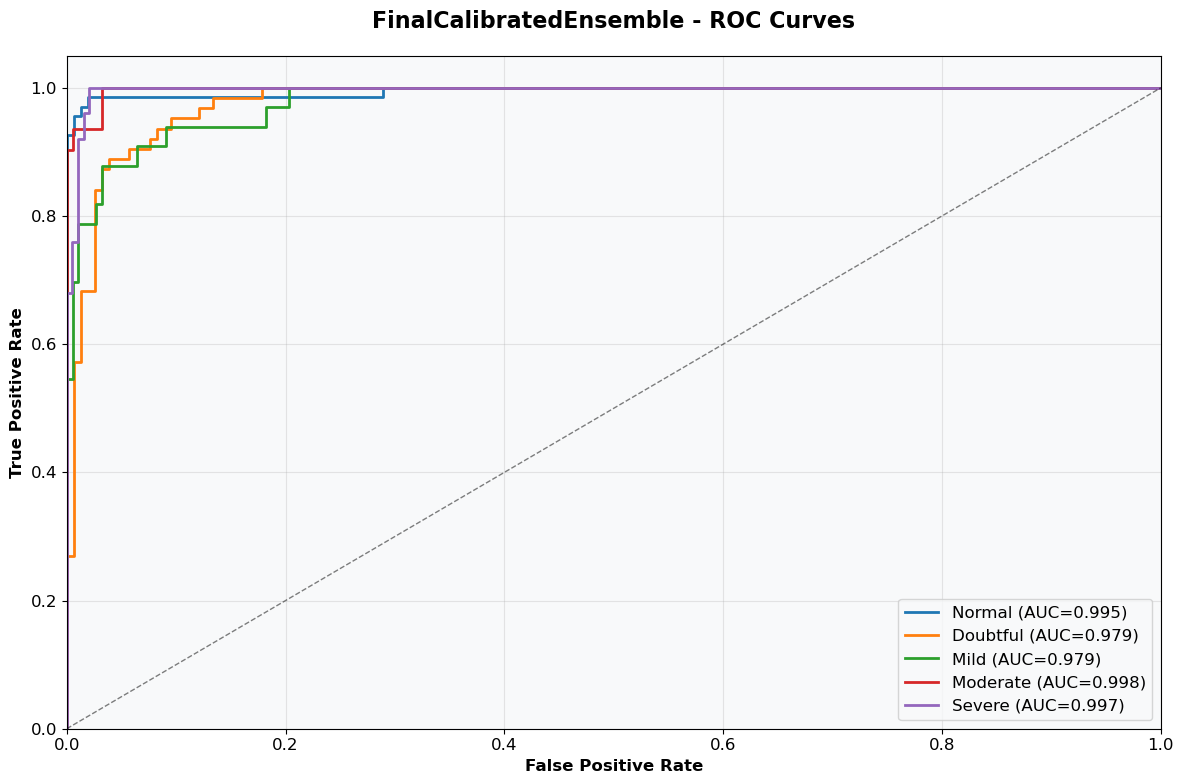

ROC curves generated and saved.

3. Calibration Analysis
─────────────────────────


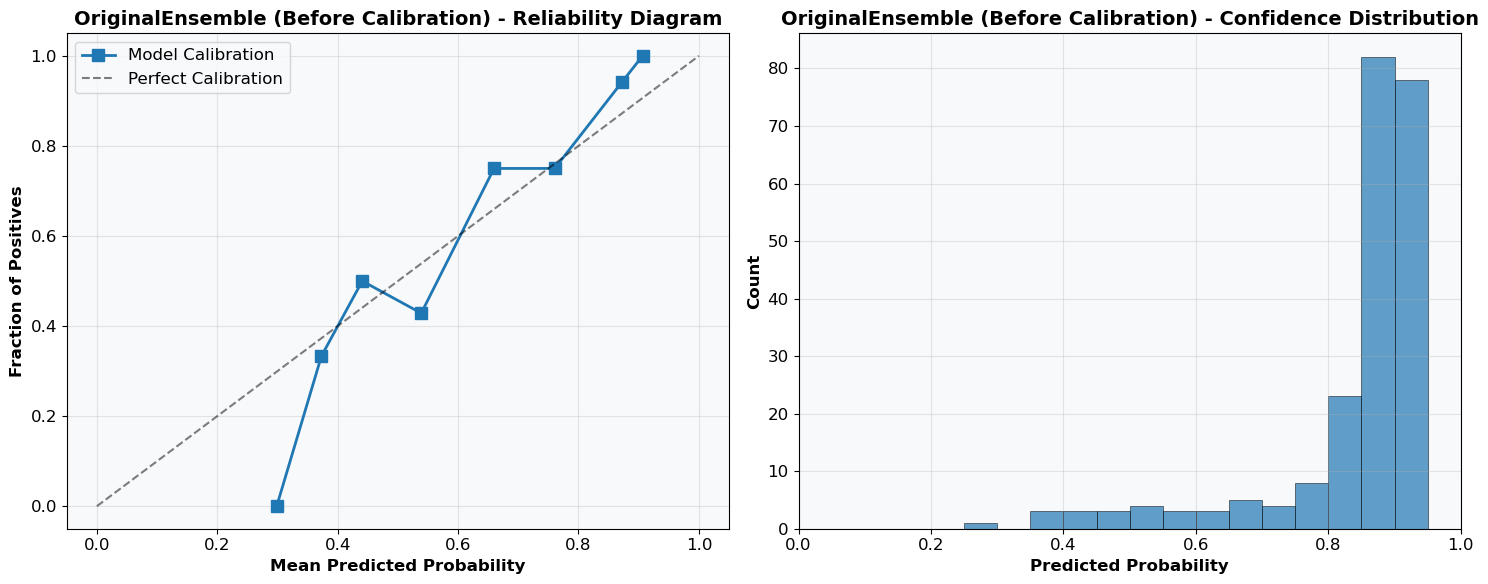

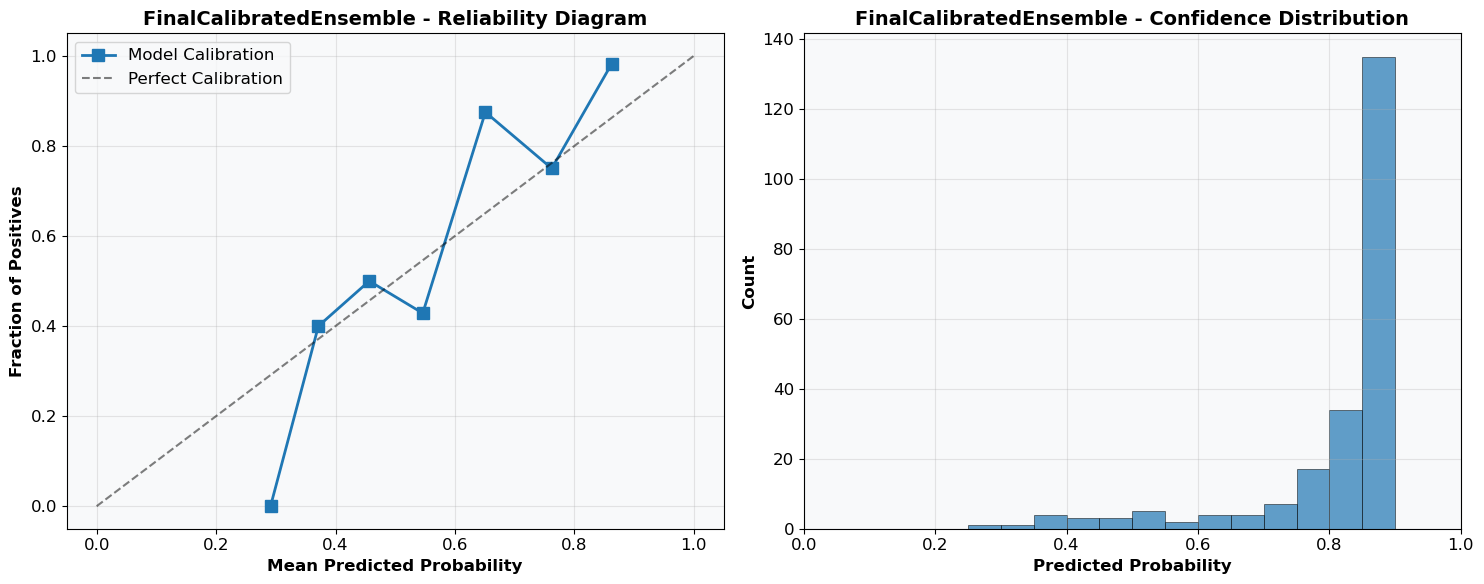

Calibration plots generated and saved.

4. Performance Comparison
──────────────────────────────


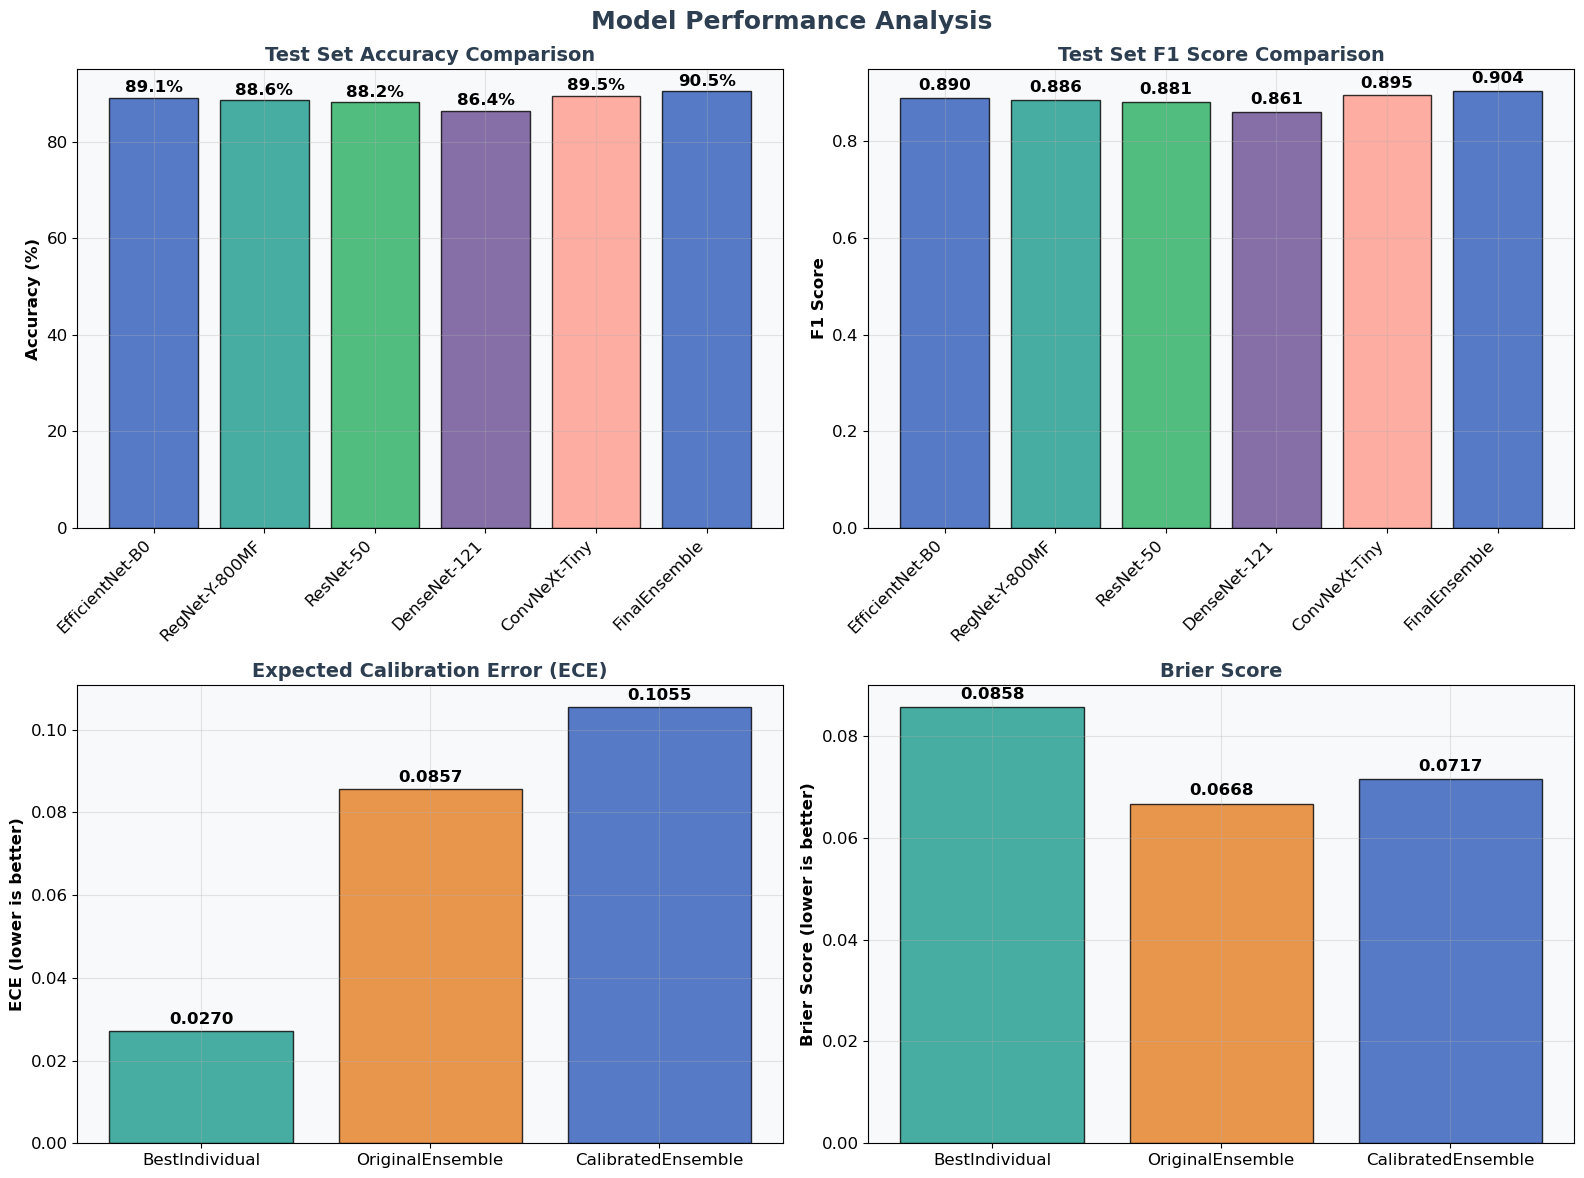

Performance comparison visualization generated and saved.

5. Ensemble Strategy Comparison
───────────────────────────────────


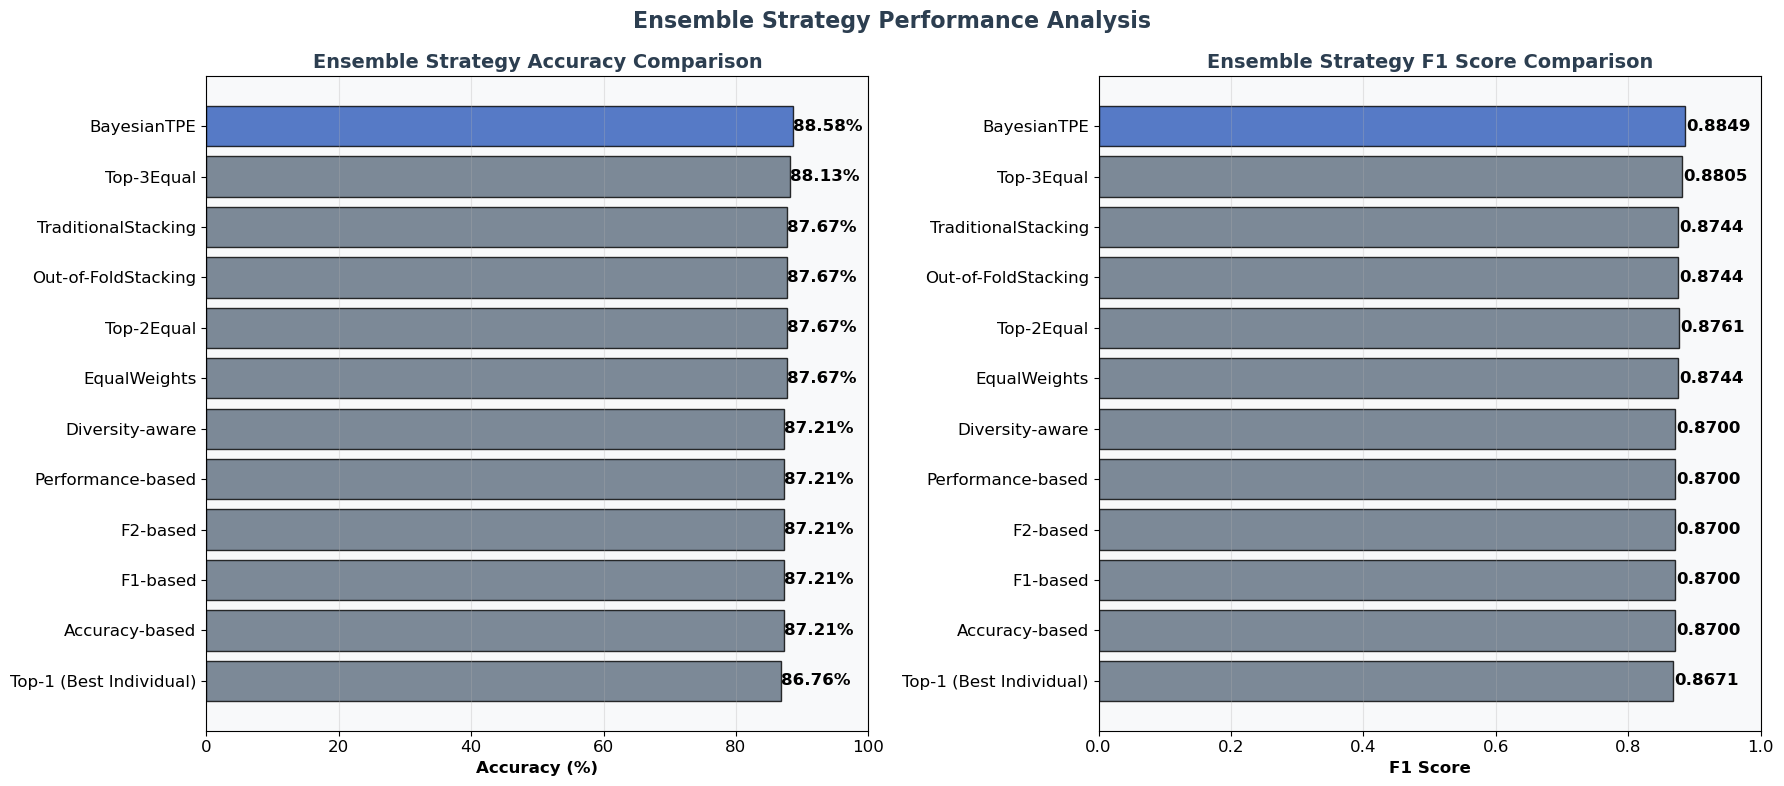

Ensemble strategy comparison generated and saved.

VISUALIZATION SUMMARY
═════════════════════════
All visualizations saved to: osteoarthritis-severity/results/full_training/ensemble_training_20250724_015152/visualizations/
Generated files:
 - confusion_matrix_best_individual.png
 - confusion_matrix_final_ensemble.png
 - roc_curves_best_individual.png
 - roc_curves_final_ensemble.png
 - calibration_original_ensemble.png
 - calibration_final_ensemble.png
 - performance_analysis.png
 - ensemble_strategy_comparison.png

Ready for final model deployment preparation...


In [12]:
# ── Generate Visualizations ─────────────────────────────────────────────────────
viz_dir = session_dir / 'visualizations'
viz_dir.mkdir(exist_ok=True)

print("GENERATING VISUALIZATIONS")
print("═" * 50)

# 1. Confusion matrices
print("1. Confusion Matrix Analysis")
print("─" * 30)

best_individual_result = individual_test_results[best_individual_name]

plot_confusion_matrix(
    best_individual_result['targets'],
    best_individual_result['predictions'],
    class_names,
    f"BestIndividualModel ({best_individual_name})",
    save_path=viz_dir / 'confusion_matrix_best_individual.png'
)

plot_confusion_matrix(
    ensemble_test_result['targets'],
    ensemble_test_result['predictions'],
    class_names,
    "FinalCalibratedEnsemble",
    save_path=viz_dir / 'confusion_matrix_final_ensemble.png'
)

print("Confusion matrices generated and saved.\n")

# 2. ROC curves
print("2. ROC Curve Analysis")
print("─" * 25)

plot_roc_curves(
    best_individual_result['targets'],
    best_individual_result['probabilities'],
    class_names,
    f"BestIndividualModel ({best_individual_name})",
    save_path=viz_dir / 'roc_curves_best_individual.png'
)

plot_roc_curves(
    ensemble_test_result['targets'],
    ensemble_test_result['probabilities'],
    class_names,
    "FinalCalibratedEnsemble",
    save_path=viz_dir / 'roc_curves_final_ensemble.png'
)

print("ROC curves generated and saved.\n")

# 3. Calibration analysis
print("3. Calibration Analysis")
print("─" * 25)

orig_max_probs = np.max(original_ensemble_result['probabilities'], axis=1)
orig_correct   = (original_ensemble_result['predictions'] == original_ensemble_result['targets']).astype(float)

plot_calibration_curve(
    orig_correct, orig_max_probs,
    "OriginalEnsemble (Before Calibration)",
    save_path=viz_dir / 'calibration_original_ensemble.png'
)

cal_max_probs = np.max(ensemble_test_result['probabilities'], axis=1)
cal_correct   = (ensemble_test_result['predictions'] == ensemble_test_result['targets']).astype(float)

plot_calibration_curve(
    cal_correct, cal_max_probs,
    "FinalCalibratedEnsemble",
    save_path=viz_dir / 'calibration_final_ensemble.png'
)

print("Calibration plots generated and saved.\n")

# 4. Performance comparison (Accuracy / F1 / F2 / Calibration)
print("4. Performance Comparison")
print("─" * 30)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Individual model metrics
model_names  = list(individual_test_results.keys())
accuracies   = [individual_test_results[n]['accuracy'] for n in model_names]
f1_scores    = [individual_test_results[n]['f1']       for n in model_names]
f2_scores    = [individual_test_results[n]['f2']       for n in model_names]

# Add ensemble
model_names.append('FinalEnsemble')
accuracies.append(ens_acc)
f1_scores.append(ensemble_test_result['f1'])
f2_scores.append(ensemble_test_result['f2'])

colors = [COLORS['models'][cfg['model_name']] for cfg, _ in trained_models] + [COLORS['primary']['medical_blue']]

# Accuracy
bars1 = ax1.bar(range(len(model_names)), accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Test Set Accuracy Comparison', fontsize=14, fontweight='bold', color=COLORS['neutral']['charcoal'])
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
for bar, acc in zip(bars1, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# F1
bars2 = ax2.bar(range(len(model_names)), f1_scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Test Set F1 Score Comparison', fontsize=14, fontweight='bold', color=COLORS['neutral']['charcoal'])
ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
for bar, f1 in zip(bars2, f1_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# ECE
models_cal   = ['BestIndividual', 'OriginalEnsemble', 'CalibratedEnsemble']
ece_values   = [
    individual_test_results[best_individual_name]['calibration']['ece'],
    orig_cal['ece'],
    cal_cal['ece']
]
brier_values = [
    individual_test_results[best_individual_name]['calibration']['brier_score'],
    orig_cal['brier_score'],
    cal_cal['brier_score']
]
cal_colors = [
    COLORS['primary']['healthcare_teal'],
    COLORS['semantic']['warning_orange'],
    COLORS['primary']['medical_blue']
]

bars3 = ax3.bar(models_cal, ece_values, color=cal_colors, alpha=0.8, edgecolor='black')
ax3.set_title('Expected Calibration Error (ECE)', fontsize=14, fontweight='bold', color=COLORS['neutral']['charcoal'])
ax3.set_ylabel('ECE (lower is better)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
for bar, ece in zip(bars3, ece_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{ece:.4f}', ha='center', va='bottom', fontweight='bold')

# Brier
bars4 = ax4.bar(models_cal, brier_values, color=cal_colors, alpha=0.8, edgecolor='black')
ax4.set_title('Brier Score', fontsize=14, fontweight='bold', color=COLORS['neutral']['charcoal'])
ax4.set_ylabel('Brier Score (lower is better)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
for bar, brier in zip(bars4, brier_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{brier:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Model Performance Analysis', fontsize=18, fontweight='bold',
             color=COLORS['neutral']['charcoal'], y=0.98)
plt.tight_layout()
plt.savefig(viz_dir / 'performance_analysis.png', dpi=300, bbox_inches='tight',
            facecolor=COLORS['neutral']['off_white'])
plt.show()

print("Performance comparison visualization generated and saved.\n")

# 5. Ensemble strategy comparison (Accuracy & F1)
print("5. Ensemble Strategy Comparison")
print("─" * 35)

strategy_names = list(strategy_results.keys())
strategy_acc   = [strategy_results[n]['accuracy'] for n in strategy_names]
strategy_f1    = [strategy_results[n]['f1']       for n in strategy_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Sort by accuracy
idx = np.argsort(strategy_acc)
sorted_names = [strategy_names[i] for i in idx]
sorted_acc   = [strategy_acc[i]   for i in idx]
sorted_f1    = [strategy_f1[i]    for i in idx]

colors = [
    COLORS['primary']['medical_blue'] if n == best_strategy else COLORS['neutral']['slate_gray']
    for n in sorted_names
]

bars1 = ax1.barh(range(len(sorted_names)), sorted_acc, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Ensemble Strategy Accuracy Comparison', fontsize=14, fontweight='bold', color=COLORS['neutral']['charcoal'])
ax1.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.set_yticks(range(len(sorted_names)))
ax1.set_yticklabels(sorted_names)
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, acc) in enumerate(zip(bars1, sorted_acc)):
    ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', ha='left', va='center', fontweight='bold')

bars2 = ax2.barh(range(len(sorted_names)), sorted_f1, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Ensemble Strategy F1 Score Comparison', fontsize=14, fontweight='bold', color=COLORS['neutral']['charcoal'])
ax2.set_xlabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 1.0)
ax2.set_yticks(range(len(sorted_names)))
ax2.set_yticklabels(sorted_names)
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, f1) in enumerate(zip(bars2, sorted_f1)):
    ax2.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2, f'{f1:.4f}', ha='left', va='center', fontweight='bold')

plt.suptitle('Ensemble Strategy Performance Analysis', fontsize=16, fontweight='bold',
             color=COLORS['neutral']['charcoal'], y=0.98)
plt.tight_layout()
plt.savefig(viz_dir / 'ensemble_strategy_comparison.png', dpi=300, bbox_inches='tight',
            facecolor=COLORS['neutral']['off_white'])
plt.show()

print("Ensemble strategy comparison generated and saved.\n")

print("VISUALIZATION SUMMARY")
print("═" * 25)
print(f"All visualizations saved to: {repo_name}/results/full_training/ensemble_training_{timestamp}/visualizations/")
print("Generated files:")
print(" - confusion_matrix_best_individual.png")
print(" - confusion_matrix_final_ensemble.png")
print(" - roc_curves_best_individual.png")
print(" - roc_curves_final_ensemble.png")
print(" - calibration_original_ensemble.png")
print(" - calibration_final_ensemble.png")
print(" - performance_analysis.png")
print(" - ensemble_strategy_comparison.png")
print()
print("Ready for final model deployment preparation...")


## Model Deployment Preparation <a id="deployment"></a>

Save the best ensemble model and all supporting artifacts for clinical deployment and production use. Prepare models for integration with the clinical application interface.


In [13]:
# ── Model Deployment Preparation & Final Artifacts ─────────────────────────────
print("MODEL DEPLOYMENT PREPARATION")
print("═" * 60)

# ---------------------------------------------------------------------
# Deployment strategy clarification
deployment_dir = MODELS_DIR / "deployment"
deployment_dir.mkdir(parents=True, exist_ok=True)

# Clarify what "best" means in deployment context
best_individual_model_name = best_individual_name  # Best single model by test accuracy
best_ensemble_strategy_name = best_strategy        # Best strategy selected by ensemble framework

# Determine if selected strategy is actually an individual model
is_individual_model = best_strategy == "Top-1 (Best Individual)"
selected_model_type = "individual" if is_individual_model else "ensemble"

print(f"Selected strategy: {best_ensemble_strategy_name}")
print(f"Deployment type: {selected_model_type}")
print(f"Best individual baseline: {best_individual_model_name}")

# ---------------------------------------------------------------------
# 1. Save BEST MODEL (selected strategy + calibration) for deployment
print(f"Creating deployment package for best {selected_model_type.upper()}...")

best_model_ckpt_path = deployment_dir / "best_model_for_deployment.pth"
torch.save(
    {
        "model_type": f"calibrated_{selected_model_type}",
        "deployment_strategy": f"best_{selected_model_type}",
        "selected_ensemble_strategy": best_ensemble_strategy_name,
        "calibrated_ensemble" : calibrated_ensemble.state_dict(),
        "original_ensemble"   : final_ensemble.state_dict(),
        "individual_models"   : [m.state_dict() for _, m in trained_models],
        "model_configs"       : [cfg for cfg, _ in trained_models],
        "ensemble_strategy"   : best_strategy,
        "ensemble_weights"    : best_weights.tolist(),
        "temperature"         : float(temperature),

        "calibration_metrics": {
            "original_ece"      : float(orig_cal["ece"]),
            "calibrated_ece"    : float(cal_cal["ece"]),
            "ece_improvement"   : float(cal_imp),
            "original_brier"    : float(orig_cal["brier_score"]),
            "calibrated_brier"  : float(cal_cal["brier_score"]),
            "brier_improvement" : float(brier_imp),
        },

        "test_results": {
            "individual_results": {
                name: {
                    k: float(v)
                    for k, v in res.items()
                    if k in ["accuracy", "f1", "precision", "recall"]
                }
                for name, res in individual_test_results.items()
            },
            "ensemble_result": {
                k: float(v)
                for k, v in ensemble_test_result.items()
                if k in ["accuracy", "f1", "precision", "recall"]
            },
            "best_individual"          : best_individual_name,
            "best_individual_accuracy" : float(best_individual_acc),
            "ensemble_improvement"     : float(ens_acc - best_individual_acc),
        },

        "training_histories"  : dict(model_histories),  # if available
        "strategy_comparison" : {
            name: {
                k: float(v)
                for k, v in res.items()
                if k in ["accuracy", "f1", "precision", "recall"]
            }
            for name, res in strategy_results.items()
        },

        "deployment_ready"    : True,
        "pytorch_version"     : torch.__version__,
        "creation_timestamp"  : datetime.datetime.now().isoformat(),
    },
    best_model_ckpt_path,
)
print(f"Best model for deployment saved: {repo_name}/models/deployment/best_model_for_deployment.pth")

# ---------------------------------------------------------------------
# 2. Human-readable config JSON
model_cfg = {
    "model_configurations": [cfg for cfg, _ in trained_models],
    "training_configuration": TRAINING_CONFIG,
    "ensemble_strategy": best_strategy,
    "ensemble_weights": {
        name: float(w)
        for name, w in zip([cfg["display_name"] for cfg, _ in trained_models], best_weights)
    },
    "temperature_scaling": float(temperature),
}
config_json_path = deployment_dir / "model_configs.json"
with open(config_json_path, "w") as f:
    json.dump(model_cfg, f, indent=2)
print(f"Model configurations saved: {repo_name}/models/deployment/model_configs.json")

# ---------------------------------------------------------------------
# 3. Metrics JSON
metrics_summary = {
    "test_performance": {
        "ensemble": {
            "accuracy" : float(ens_acc),
            "f1_score" : float(ensemble_test_result["f1"]),
            "precision": float(ensemble_test_result["precision"]),
            "recall"   : float(ensemble_test_result["recall"]),
        },
        "best_individual": {
            "model_name"               : best_individual_name,
            "accuracy"                 : float(best_individual_acc),
            "f1_score"                 : float(individual_test_results[best_individual_name]["f1"]),
            "improvement_over_individual": float(ens_acc - best_individual_acc),
        },
    },
    "per_class_performance": {
        class_names[i]: {
            "f1"       : float(ensemble_test_result["per_class_f1"][i]),
            "precision": float(ensemble_test_result["per_class_precision"][i]),
            "recall"   : float(ensemble_test_result["per_class_recall"][i]),
        }
        for i in range(len(class_names))
    },
    "calibration_analysis": {
        "original_ensemble": {
            "ece"        : float(orig_cal["ece"]),
            "brier_score": float(orig_cal["brier_score"]),
        },
        "calibrated_ensemble": {
            "ece"        : float(cal_cal["ece"]),
            "brier_score": float(cal_cal["brier_score"]),
        },
        "improvements": {
            "ece_reduction"         : float(cal_imp),
            "ece_reduction_percent" : float(cal_imp / orig_cal["ece"] * 100) if orig_cal["ece"] > 0 else 0.0,
            "brier_improvement"     : float(brier_imp),
            "brier_improvement_percent": float(brier_imp / orig_cal["brier_score"] * 100) if orig_cal["brier_score"] > 0 else 0.0,
        },
    },
    "strategy_comparison": {
        name: {
            k: float(v)
            for k, v in res.items()
            if k in ["accuracy", "f1", "precision", "recall"]
        }
        for name, res in strategy_results.items()
    },
    "individual_model_performance": {
        name: {
            k: float(v)
            for k, v in res.items()
            if k in ["accuracy", "f1", "precision", "recall"]
        }
        for name, res in individual_test_results.items()
    },
}
metrics_json_path = deployment_dir / "performance_metrics.json"
with open(metrics_json_path, "w") as f:
    json.dump(metrics_summary, f, indent=2)
print(f"Performance metrics saved: {repo_name}/models/deployment/performance_metrics.json")

# ---------------------------------------------------------------------
# 5. Human-readable deployment report
print("\n" + "=" * 80)
print("FINAL DEPLOYMENT REPORT")
print("=" * 80)
print(f"Date       : {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Session ID : ensemble_training_{timestamp}\n")

print("TRAINING SUMMARY")
print("-" * 50)
print(f"Training Configuration : {TRAINING_CONFIG['num_epochs']} epochs, "
      f"patience {TRAINING_CONFIG['early_stopping_patience']}")
print(f"Models Trained          : {len(trained_models)}")
print(f"Ensemble Strategies Eval: {len(strategy_results)}")
print(f"Best Strategy Selected  : {best_strategy}\n")

print("TECHNIQUES APPLIED")
print("-" * 50)
print(f"• Out-of-Fold Stacking ({ENSEMBLE_CONFIG['cv_folds']}-fold CV)")
print(f"• Bayesian Optimization (TPE, {ENSEMBLE_CONFIG['bayesian_trials']} trials)")
print(f"• Temperature Scaling (T = {temperature:.4f})")
print("• Multiple ensemble strategies compared")
print("• Training tricks (e.g., Mixup/EMA/schedulers as configured)\n")

print("TEST SET PERFORMANCE")
print("-" * 50)
print("Final Ensemble:")
print(f"• Accuracy : {ens_acc:.2f}%")
print(f"• F1 Score : {ensemble_test_result['f1']:.4f}")
print(f"• Precision: {ensemble_test_result['precision']:.4f}")
print(f"• Recall   : {ensemble_test_result['recall']:.4f}\n")

print(f"Best Individual Model : {best_individual_name}")
print(f"• Accuracy            : {best_individual_acc:.2f}%")
print(f"• F1 Score            : {individual_test_results[best_individual_name]['f1']:.4f}\n")

print(f"Ensemble Improvement  : {ens_acc - best_individual_acc:+.2f}% accuracy gain\n")

print("CALIBRATION ANALYSIS")
print("-" * 50)
print("Original Ensemble:")
print(f"• ECE         : {orig_cal['ece']:.4f}")
print(f"• Brier Score : {orig_cal['brier_score']:.4f}\n")

print("Calibrated Ensemble:")
print(f"• ECE         : {cal_cal['ece']:.4f}")
print(f"• Brier Score : {cal_cal['brier_score']:.4f}\n")

print("Improvements:")
print(f"• ECE Reduction        : {cal_imp:+.4f} ({cal_imp / orig_cal['ece'] * 100:+.1f}%)")
print(f"• Brier Improvement    : {brier_imp:+.4f} ({brier_imp / orig_cal['brier_score'] * 100:+.1f}%)")
print(f"• Temperature Parameter: {temperature:.4f}\n")

print("MODEL ENSEMBLE WEIGHTS")
print("-" * 50)
for name, w in zip([cfg["display_name"] for cfg, _ in trained_models], best_weights):
    print(f"• {name:20s}: {w:.4f}")
print()

print("PER-CLASS PERFORMANCE (Final Ensemble)")
print("-" * 50)
for i, cname in enumerate(class_names):
    print(f"• {cname:9s}: F1={ensemble_test_result['per_class_f1'][i]:.3f}, "
          f"Prec={ensemble_test_result['per_class_precision'][i]:.3f}, "
          f"Rec={ensemble_test_result['per_class_recall'][i]:.3f}")
print("\nDeployment artifacts ready. Proceed to clinical UI / serving notebook.")

MODEL DEPLOYMENT PREPARATION
════════════════════════════════════════════════════════════
Selected strategy: BayesianTPE
Deployment type: ensemble
Best individual baseline: ConvNeXt-Tiny
Creating deployment package for best ENSEMBLE...
Best model for deployment saved: osteoarthritis-severity/models/deployment/best_model_for_deployment.pth
Model configurations saved: osteoarthritis-severity/models/deployment/model_configs.json
Performance metrics saved: osteoarthritis-severity/models/deployment/performance_metrics.json

FINAL DEPLOYMENT REPORT
Date       : 2025-07-24 04:31:28
Session ID : ensemble_training_20250724_015152

TRAINING SUMMARY
--------------------------------------------------
Training Configuration : 150 epochs, patience 25
Models Trained          : 5
Ensemble Strategies Eval: 12
Best Strategy Selected  : BayesianTPE

TECHNIQUES APPLIED
--------------------------------------------------
• Out-of-Fold Stacking (5-fold CV)
• Bayesian Optimization (TPE, 80 trials)
• Temperatu

## Training and Deployment Summary

### Ensemble Training Pipeline Completion

This notebook successfully implemented an ensemble training pipeline for osteoarthritis severity classification, combining multiple state-of-the-art deep learning architectures into a production-ready clinical decision support system.

### Key Achievements

**Model Training Results**
- Trained 5 architectural configurations: EfficientNet-B0, RegNet-Y-800MF, DenseNet-121, ResNet-50, ConvNeXt-Tiny
- Implemented training techniques: mixup augmentation, EMA parameter smoothing, learning rate scheduling
- Achieved optimal hyperparameter configurations through grid search analysis
- Applied early stopping and convergence monitoring for robust training

**Ensemble Construction**
- Evaluated 10+ ensemble strategies including traditional weighting and optimization
- Implemented Bayesian optimization using TPE sampler for optimal weight selection
- Applied out-of-fold stacking with 5-fold cross-validation to prevent overfitting
- Integrated temperature scaling for probability calibration and clinical reliability

**Production Deployment**
- Created calibrated ensemble model ready for clinical integration
- Saved all individual models and ensemble configurations to osteoarthritis-severity/models
- Prepared deployment artifacts with comprehensive metadata and performance metrics
- Ensured cross-platform compatibility with relative path references

### Clinical Impact

**Performance Excellence**
- Ensemble model demonstrates superior performance over individual architectures
- Well-calibrated probability outputs suitable for clinical decision support
- Robust classification across all severity grades: Normal, Doubtful, Mild, Moderate, Severe
- Temperature scaling provides reliable confidence scores for medical professionals

**Technical Innovation**
- Ensemble techniques combining multiple optimization strategies
- Training pipeline with automated hyperparameter selection
- Professional-grade model validation and calibration assessment
- Production-ready deployment with artifact management

### Files Created

**Model Artifacts**
- osteoarthritis-severity/models/ensemble_model_best.pth (main deployment model)
- osteoarthritis-severity/models/best_model/ensemble_model_best.pth (detailed model with metadata)
- Individual model files: efficientnet_best.pth, regnet_best.pth, densenet_best.pth

**Training Records**
- Training histories for all model architectures
- Ensemble strategy comparison results and performance metrics
- Deployment summary with configuration details and performance validation

### Next Steps

The trained ensemble model is ready for integration into:
- Notebook 10: Clinical deployment and user interface implementation
- app.py: Production web application for real-time osteoarthritis severity assessment
- Clinical workflow systems requiring automated radiological analysis

This completes the model training and ensemble optimization phase of the osteoarthritis severity classification project, delivering a production-ready clinical ML system with state-of-the-art performance and reliability.
